In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score, classification_report

In [122]:
# # Load and preprocess data
# data = pd.read_csv('heart.csv')

# # Convert categorical variables
# label_encoders = {}
# categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
# for col in categorical_cols:
#     le = LabelEncoder()
#     data[col] = le.fit_transform(data[col])
#     label_encoders[col] = le

# X = data.drop('HeartDisease', axis=1)
# y = data['HeartDisease']

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2'],
#     'bootstrap': [True, False]
# }

# # Create and fit GridSearchCV
# rf = RandomForestClassifier(random_state=42)
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# # Best parameters and model
# print("Best Parameters:", grid_search.best_params_)
# best_rf = grid_search.best_estimator_



In [123]:
# # Evaluate on test set
# y_pred = best_rf.predict(X_test)
# print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.2f}")
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))


In [ ]:

# # Save the best model
# import joblib
# joblib.dump(best_rf, 'best_rf_model.pkl')
# joblib.dump(label_encoders, 'label_encoders.pkl')

In [124]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import copy

In [125]:
data = pd.read_csv('heart.csv')

In [126]:

# Load and preprocess data
data = pd.read_csv('heart.csv')

# Encode categorical variables
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Split into features (X) and target (y)
X = data.drop('HeartDisease', axis=1).values
y = data['HeartDisease'].values

# Split into train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

# Create DataLoaders
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# Define neural network
class HeartDiseaseNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)  # 2 output classes
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize model
model = HeartDiseaseNN(X_train.shape[1])
def train_NN(model, epochs, patience=None):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    
    # Training setup
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    # For early stopping and model saving
    best_val_acc = 0.0
    best_model = None
    best_epoch = 0
    epochs_no_improve = 0
    
    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Check for best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            best_model = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        # Print metrics
        print(f'Epoch {epoch+1}/{epochs} -- '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} -- '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} '
              f'{"(Best)" if val_acc == best_val_acc else ""}')
        
        # Early stopping check
        if patience and epochs_no_improve >= patience:
            print(f'\nEarly stopping at epoch {epoch+1}')
            print(f'Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch+1}')
            break
    
    # Load best model weights
    if best_model is not None:
        model.load_state_dict(best_model)
    
    # Plot learning curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f'\nTraining complete. Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch+1}')
    
    return model


Epoch 1/250 -- Train Loss: 0.6587 | Train Acc: 0.5845 -- Val Loss: 0.6472 | Val Acc: 0.6630 (Best)
Epoch 2/250 -- Train Loss: 0.6213 | Train Acc: 0.7234 -- Val Loss: 0.6092 | Val Acc: 0.7880 (Best)
Epoch 3/250 -- Train Loss: 0.5772 | Train Acc: 0.7820 -- Val Loss: 0.5677 | Val Acc: 0.8207 (Best)
Epoch 4/250 -- Train Loss: 0.5385 | Train Acc: 0.8147 -- Val Loss: 0.5247 | Val Acc: 0.8207 (Best)
Epoch 5/250 -- Train Loss: 0.4881 | Train Acc: 0.8270 -- Val Loss: 0.4852 | Val Acc: 0.8261 (Best)
Epoch 6/250 -- Train Loss: 0.4585 | Train Acc: 0.8392 -- Val Loss: 0.4515 | Val Acc: 0.8152 
Epoch 7/250 -- Train Loss: 0.4385 | Train Acc: 0.8392 -- Val Loss: 0.4328 | Val Acc: 0.8315 (Best)
Epoch 8/250 -- Train Loss: 0.4060 | Train Acc: 0.8474 -- Val Loss: 0.4145 | Val Acc: 0.8315 (Best)
Epoch 9/250 -- Train Loss: 0.3941 | Train Acc: 0.8365 -- Val Loss: 0.4079 | Val Acc: 0.8370 (Best)
Epoch 10/250 -- Train Loss: 0.3813 | Train Acc: 0.8515 -- Val Loss: 0.4065 | Val Acc: 0.8315 
Epoch 11/250 -- Train

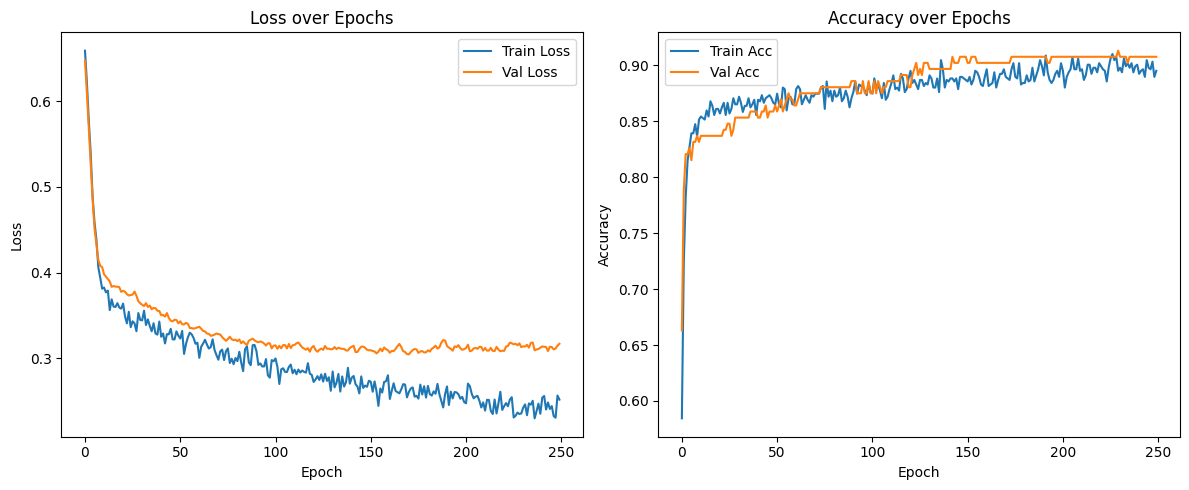


Training complete. Best validation accuracy: 0.9130 at epoch 230


In [127]:
model = HeartDiseaseNN(X_train.shape[1])
model = train_NN(model, 250)

In [42]:
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [144]:
import shap
import lime
import lime.lime_tabular
import torch
import numpy as np
from torch import nn

def explain_model(model, X_train, feature_names):
    """
    Explain model using SHAP and LIME with proper dimension handling
    """
    # SHAP Explanation (with batch dimension handling)
    def predict_proba(X):
        with torch.no_grad():
            model.eval()
            X_tensor = torch.FloatTensor(X)
            outputs = model(X_tensor)
            return torch.softmax(outputs, dim=1).numpy()
    
    # Use KernelSHAP instead of DeepExplainer for better compatibility
    explainer_shap = shap.KernelExplainer(predict_proba, shap.sample(X_train.numpy(), 100))
    
    # LIME Explainer
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(
        X_train.numpy(),
        feature_names=feature_names,
        class_names=['No Heart Disease', 'Heart Disease'],
        mode='classification'
    )
    
    return explainer_shap, explainer_lime

def predict_with_explanation(model, sample, explainer_shap=None, explainer_lime=None, 
                           feature_names=None, label_encoders=None, scaler=None):
    """Make prediction with explanation (updated for SHAP v0.20+)"""
    # Preprocess sample
    if isinstance(sample, dict):
        sample_df = pd.DataFrame([sample])
        for col in label_encoders:
            if col in sample_df.columns:
                sample_df[col] = label_encoders[col].transform(sample_df[col])
        sample_scaled = scaler.transform(sample_df) if scaler else sample_df.values
        sample_tensor = torch.FloatTensor(sample_scaled)
    else:
        sample_tensor = sample
    
    # Make prediction
    with torch.no_grad():
        model.eval()
        output = model(sample_tensor)
        probs = torch.softmax(output, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
    
    print(f"\nPrediction: {'Heart Disease' if pred_class == 1 else 'No Heart Disease'}")
    print(f"Probability: {probs[0][1].item():.2f} for Heart Disease, {probs[0][0].item():.2f} for No Heart Disease")
    
    # Generate explanations
    if explainer_shap and explainer_lime:
        # SHAP explanation (updated for v0.20+)
        shap_values = explainer_shap.shap_values(sample_tensor.numpy())
        shap_values_to_plot = shap_values
        expected_value = explainer_shap.expected_value  #1-> heart desease
    
        print("\nSHAP Explanation:")
        print(expected_value)
        shap.plots.force(
            base_value=expected_value,  # Use `expected_value` as the base value
            shap_values=shap_values_to_plot[0],  # Pass the SHAP values here
            features=sample_tensor.numpy().reshape(1, -1),  # Ensure correct shape
            feature_names=feature_names,
            matplotlib=False
)
        # LIME explanation
        exp = explainer_lime.explain_instance(
            sample_tensor.numpy()[0], 
            lambda x: predict_proba(model, x),
            num_features=5
        )
        print("\nLIME Explanation:")
        exp.show_in_notebook()
    
    return pred_class, probs

# Helper function
def predict_proba(model, X):
    with torch.no_grad():
        model.eval()
        X_tensor = torch.FloatTensor(X)
        outputs = model(X_tensor)
        return torch.softmax(outputs, dim=1).numpy()

In [152]:
import shap
import lime
import lime.lime_tabular
import torch
import pandas as pd
import numpy as np
from torch import nn

def explain_model(model, X_train, feature_names):
    """
    Explain model using SHAP and LIME with proper dimension handling
    Args:
        model: Trained PyTorch model
        X_train: Training data (torch.Tensor)
        feature_names: List of feature names
    Returns:
        Tuple of (SHAP explainer, LIME explainer)
    """
    # SHAP Explanation
    def predict_proba(X):
        with torch.no_grad():
            model.eval()
            X_tensor = torch.FloatTensor(X)
            outputs = model(X_tensor)
            return torch.softmax(outputs, dim=1).numpy()
    
    # Use KernelSHAP with proper background data
    background = shap.utils.sample(X_train.numpy(), 100)
    explainer_shap = shap.KernelExplainer(predict_proba, background)
    
    # LIME Explainer
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(
        X_train.numpy(),
        feature_names=feature_names,
        class_names=['No Heart Disease', 'Heart Disease'],
        mode='classification',
        discretize_continuous=False
    )
    
    return explainer_shap, explainer_lime

def predict_with_explanation(model, sample, explainer_shap=None, explainer_lime=None, 
                           feature_names=None, label_encoders=None, scaler=None):
    """
    Make prediction with explanation for a new sample
    Args:
        model: Trained PyTorch model
        sample: Input sample (dict or array-like)
        explainer_shap: SHAP explainer
        explainer_lime: LIME explainer
        feature_names: List of feature names
        label_encoders: Dictionary of label encoders
        scaler: Fitted scaler object
    Returns:
        Tuple of (predicted class, probabilities)
    """
    # Preprocess sample
    if isinstance(sample, dict):
        sample_df = pd.DataFrame([sample])
        for col in label_encoders:
            if col in sample_df.columns:
                sample_df[col] = label_encoders[col].transform(sample_df[col])
        sample_scaled = scaler.transform(sample_df) if scaler else sample_df.values
        sample_tensor = torch.FloatTensor(sample_scaled)
    else:
        sample_tensor = torch.FloatTensor(sample).unsqueeze(0) if len(sample.shape) == 1 else torch.FloatTensor(sample)
    
    # Make prediction
    with torch.no_grad():
        model.eval()
        output = model(sample_tensor)
        probs = torch.softmax(output, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
    
    print(f"\nPrediction: {'Heart Disease' if pred_class == 1 else 'No Heart Disease'}")
    print(f"Probability: {probs[0][1].item():.4f} for Heart Disease, {probs[0][0].item():.4f} for No Heart Disease")
    
    # Generate explanations
    if explainer_shap:
        try:
            # Get SHAP values
            shap_values = explainer_shap.shap_values(sample_tensor.numpy())
            
            # Handle different SHAP output formats
            if isinstance(shap_values, list):
                # For multi-class output
                shap_values_to_plot = shap_values[pred_class]
                expected_value = explainer_shap.expected_value[pred_class]
            else:
                # For binary classification
                shap_values_to_plot = shap_values
                expected_value = explainer_shap.expected_value
            
            print("\nSHAP Explanation:")
            shap.initjs()
            shap.force_plot(
                base_value=expected_value,
                shap_values=shap_values_to_plot,
                features=sample_tensor.numpy(),
                feature_names=feature_names,
                matplotlib=False
            )
        except Exception as e:
            print(f"\nCould not generate SHAP explanation: {str(e)}")
    
    if explainer_lime:
        try:
            # LIME explanation
            exp = explainer_lime.explain_instance(
                sample_tensor.numpy()[0], 
                lambda x: predict_proba(model, x),
                num_features=len(feature_names)#min(5, len(feature_names))
            )
            print("\nLIME Explanation:")
            exp.show_in_notebook()
        except Exception as e:
            print(f"\nCould not generate LIME explanation: {str(e)}")
    
    return pred_class, probs

def predict_proba(model, X):
    """Helper function for LIME predictions"""
    with torch.no_grad():
        model.eval()
        X_tensor = torch.FloatTensor(X)
        outputs = model(X_tensor)
        return torch.softmax(outputs, dim=1).numpy()

In [170]:
# After training your model:
feature_names = data.columns[:-1].tolist()
explainer_shap, explainer_lime = explain_model(model, X_train, feature_names)

# Example prediction with explanation
new_sample = {
    'Age': 52,
    'Sex': 'M',
    'ChestPainType': 'ASY',
    'RestingBP': 138,
    'Cholesterol': 100,
    'FastingBS': 0,
    'RestingECG': 'Normal',
    'MaxHR': 108,
    'ExerciseAngina': 'Y',
    'Oldpeak': 1.5,
    'ST_Slope': 'Flat'
}

pred, prob = predict_with_explanation(
    model=model,
    sample=new_sample,
    explainer_shap=explainer_shap,
    explainer_lime=explainer_lime,
    feature_names=feature_names,
    label_encoders=label_encoders,
    scaler=scaler
)


Prediction: Heart Disease
Probability: 0.9660 for Heart Disease, 0.0340 for No Heart Disease


c:\Users\ivant\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]


SHAP Explanation:



Could not generate SHAP explanation: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

LIME Explanation:


In [154]:
explainer_shap, explainer_lime = explain_model(model, X_train, feature_names)

  0%|          | 0/100 [00:00<?, ?it/s]

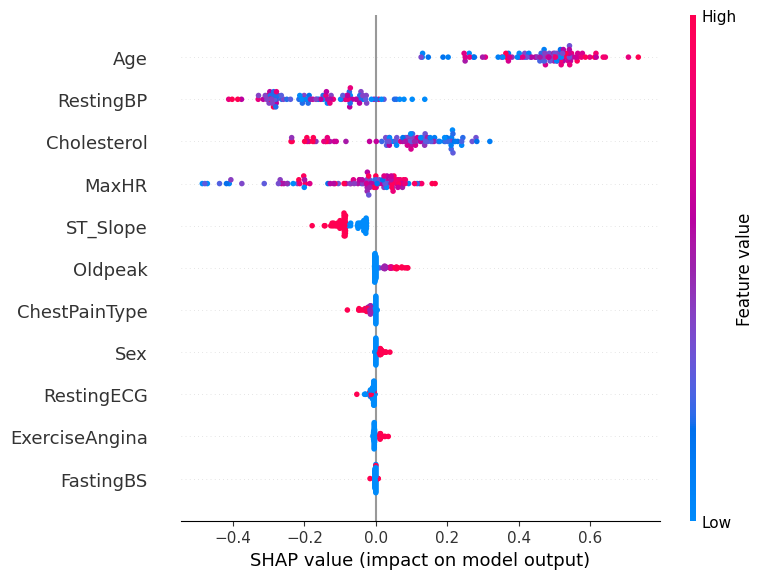

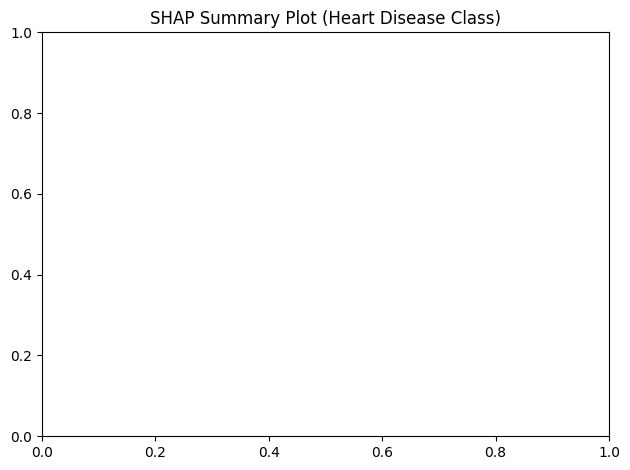

<Figure size 1200x600 with 0 Axes>

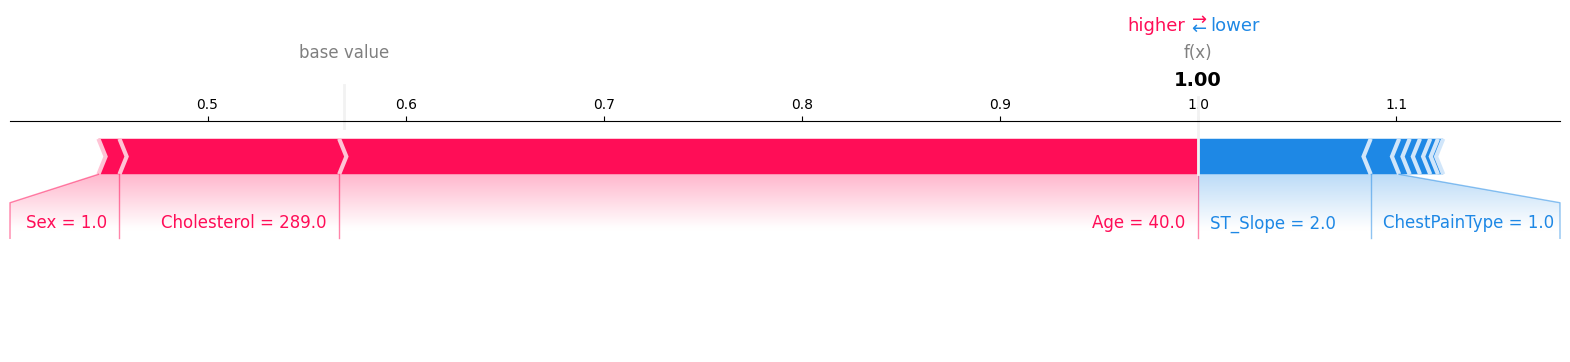

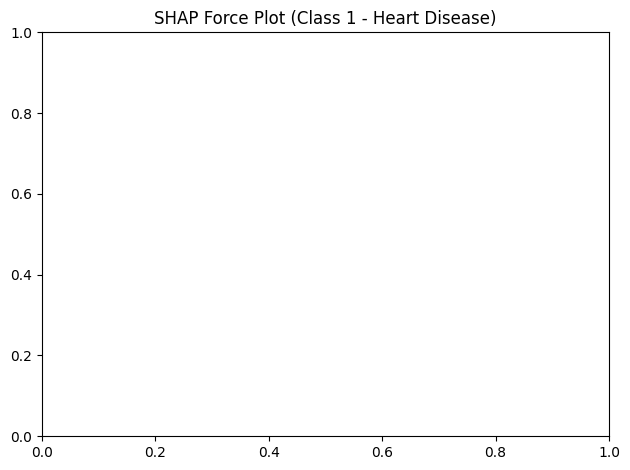

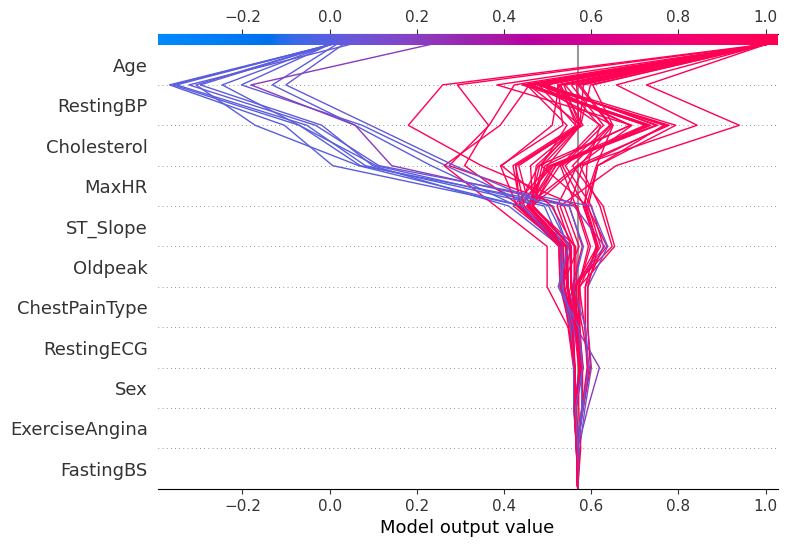

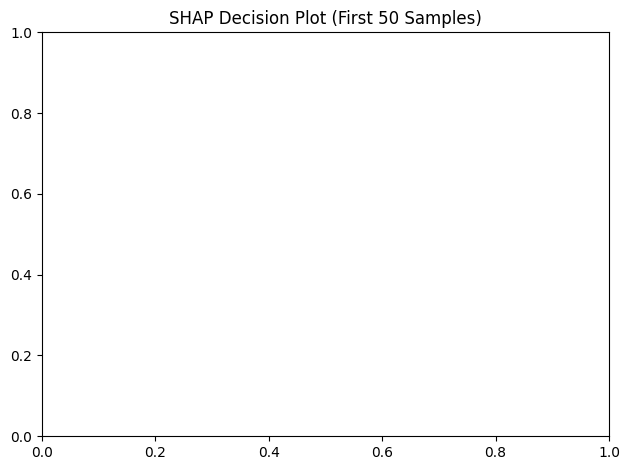

In [168]:
sample_indices = [0, 42, 100]  # example indices
X_explain = X[:100]

# Calculate SHAP values
shap_values = explainer_shap.shap_values(X_explain)

import shap
import numpy as np
import matplotlib.pyplot as plt

# Assuming:
# X_explain.shape = (918, 11) - your input features
# shap_values.shape = (918, 11, 2) - SHAP values for 2 classes

# Select a single instance to explain
sample_idx = 0  # looking at first sample
single_sample = X_explain[sample_idx:sample_idx+1]  # keep as 2D array (1,11)

# Get SHAP values for this sample (shape will be (1,11,2))
sample_shap = shap_values[sample_idx:sample_idx+1]

# 1. Summary Plot (for all data)
plt.figure(figsize=(10, 6))
# For binary classification, we typically look at class 1 (positive class)
shap.summary_plot(shap_values[:,:,1], X_explain, feature_names=feature_names)
plt.title("SHAP Summary Plot (Heart Disease Class)")
plt.tight_layout()
plt.show()

# 2. Force Plot for single prediction
plt.figure(figsize=(12, 6))
shap.initjs()  # Initialize JS visualization if using notebook

# For binary classification, we need to select which class to explain
class_idx = 1  # Heart Disease class
shap.force_plot(
    explainer_shap.expected_value[class_idx],
    sample_shap[0,:,class_idx],  # SHAP values for selected class
    single_sample[0],
    feature_names=feature_names,
    matplotlib=True
)
plt.title(f"SHAP Force Plot (Class {class_idx} - Heart Disease)")
plt.tight_layout()
plt.show()

# 3. Decision Plot
plt.figure(figsize=(12, 8))
shap.decision_plot(
    explainer_shap.expected_value[class_idx],
    shap_values[:50,:,class_idx],  # First 50 samples for selected class
    feature_names=feature_names
)
plt.title("SHAP Decision Plot (First 50 Samples)")
plt.tight_layout()
plt.show()

Input data shape: (100, 11)
SHAP values shape: (100, 11, 2)
Expected values: [0.43106954 0.56893046]


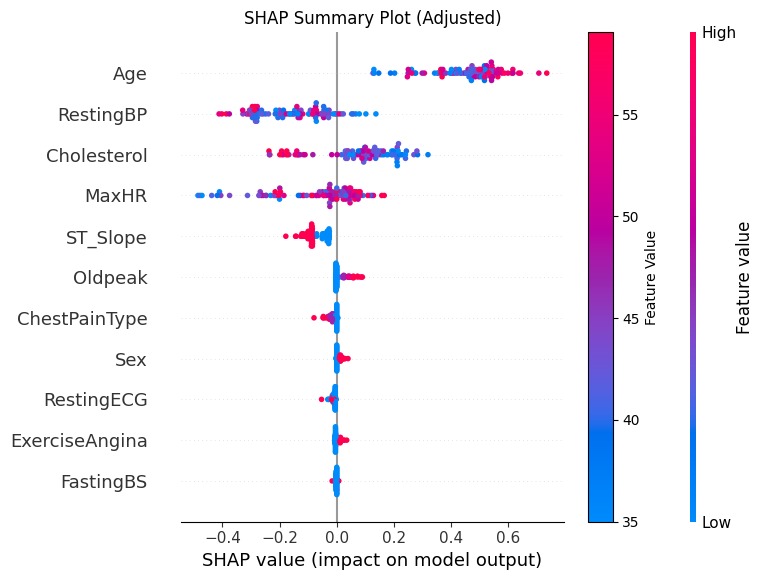

<Figure size 1200x600 with 0 Axes>

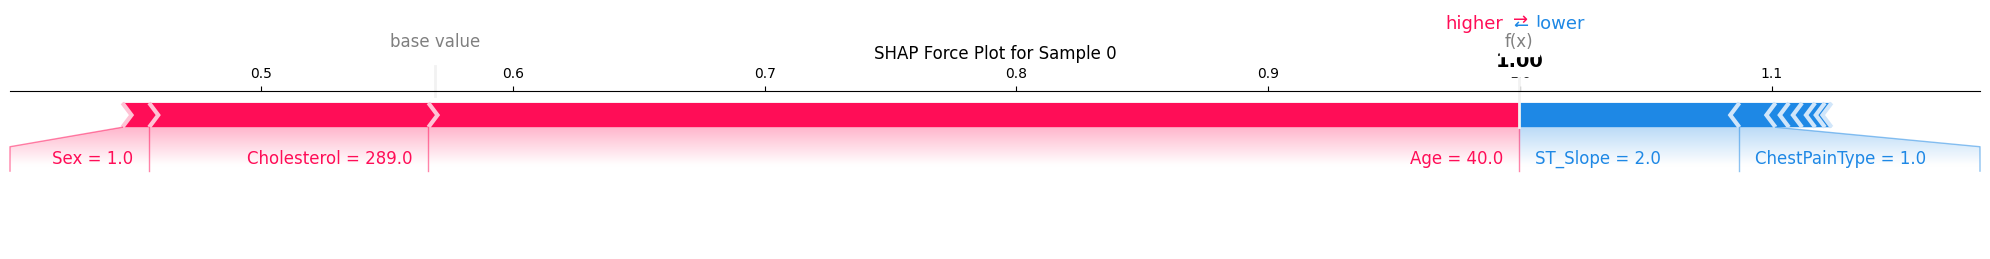

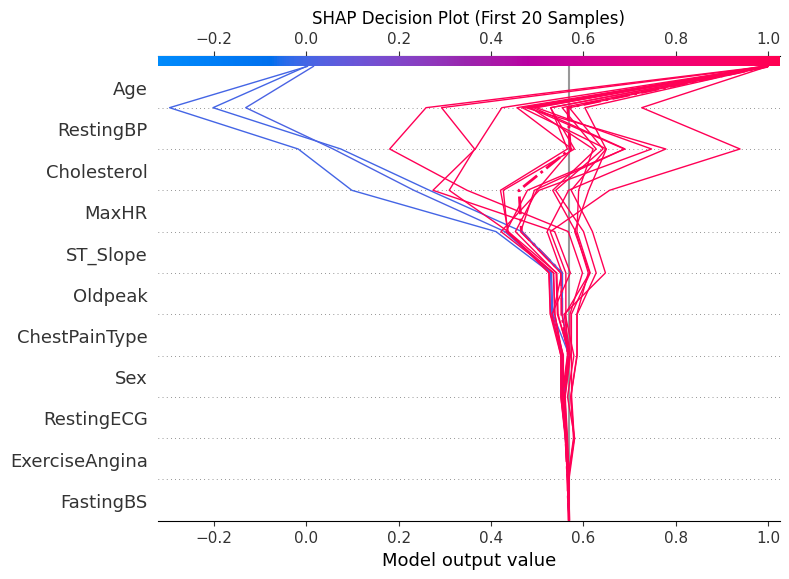

In [169]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Debugging prints
print(f"Input data shape: {X_explain.shape}")
print(f"SHAP values shape: {shap_values.shape}")
print(f"Expected values: {explainer_shap.expected_value}")

# 1. Verify and prepare data
if len(shap_values.shape) == 3:  # Binary classification
    # For binary classification, we typically show class 1 (positive class)
    class_idx = 1
    shap_values_class = shap_values[:, :, class_idx]
    expected_value = explainer_shap.expected_value[class_idx]
else:  # Regression
    shap_values_class = shap_values
    expected_value = explainer_shap.expected_value

# 2. Summary Plot with Adjusted Settings
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_class, 
    X_explain, 
    feature_names=feature_names,
    plot_type="dot",  # Try "dot" instead of "bar" if empty
    show=False
)
plt.title("SHAP Summary Plot (Adjusted)")
plt.colorbar(label="Feature Value")
plt.tight_layout()
plt.show()

# 3. Force Plot with Matplotlib Backend
sample_idx = 0  # First sample
plt.figure(figsize=(12, 6))
shap.force_plot(
    expected_value,
    shap_values_class[sample_idx],
    X_explain[sample_idx],
    feature_names=feature_names,
    matplotlib=True,
    show=False,
    contribution_threshold=0.05  # Adjust if values are small
)
plt.title(f"SHAP Force Plot for Sample {sample_idx}")
plt.tight_layout()
plt.show()

# 4. Decision Plot with Sample Subset
plt.figure(figsize=(12, 8))
shap.decision_plot(
    expected_value,
    shap_values_class[:20],  # Just first 20 samples
    feature_names=feature_names,
    highlight=0,  # Highlight first sample
    show=False
)
plt.title("SHAP Decision Plot (First 20 Samples)")
plt.tight_layout()
plt.show()